In [1]:
import os
from pathlib import Path
from functools import partial
from typing import cast

import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

from src.model import Autoencoder
from src.datasets.mvtec_ad import MVTecAD
from src.persistence import load_model
from src.preprocessing import ImagePreprocessing

DATASET_DIR = Path(os.environ["AD_DATASET_DIR"])
SAVED_MODEL = Path("..") / os.environ["SAVED_MODEL"]
HISTORY_FILE = Path("..") / os.environ["HISTORY_FILE"]

<Axes: xlabel='epoch'>

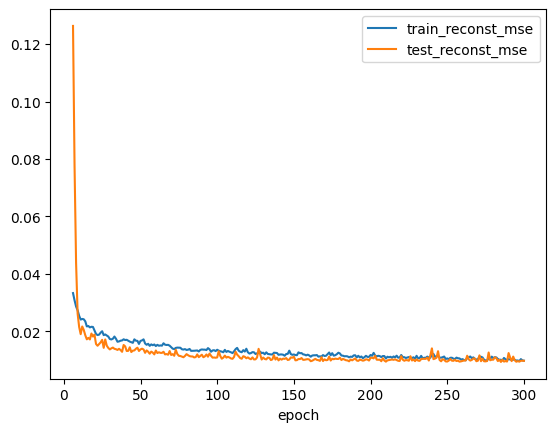

In [2]:
df_history = pd.read_csv(HISTORY_FILE)
df_history[df_history["epoch"] > 5].plot(x="epoch", y=["train_reconst_mse", "test_reconst_mse"])

In [3]:
def binary_labels(label: int) -> int:
    return 0 if label == 0 else 1

create_ds = partial(
        MVTecAD,
        dataset_dir=Path(os.environ["AD_DATASET_DIR"]),
        object=os.environ["AD_OBJECT"],
        sample_transform=ImagePreprocessing(
            target_img_width=int(os.environ["IMAGE_WIDTH"]),
            target_img_height=int(os.environ["IMAGE_HEIGHT"]),
        ),
        target_transform=binary_labels,
    )
ds_train, ds_test = create_ds(training_set=True), create_ds(training_set=False)

In [4]:
model = Autoencoder()
load_model(model, SAVED_MODEL)
model.eval()

Autoencoder(
  (encoder): Encoder(
    (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=same, groups=3)
    (1): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
    (2): ReLU()
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same, groups=64)
    (6): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same, groups=128)
    (11): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
    (12): ReLU()
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): MaxPool2d(kernel_size=2, stride=2, 

Text(0.5, 1.0, 'Reconstructed')

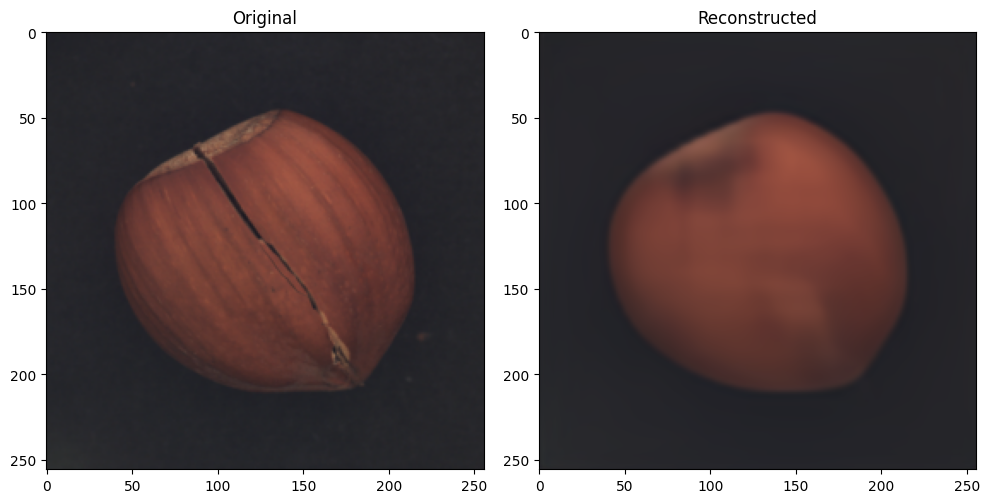

In [5]:
img_original, _ = cast(torch.Tensor, ds_test[50])
with torch.no_grad():
    img_reconstr = cast(torch.Tensor, model(img_original.unsqueeze(dim=0))).squeeze()

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), tight_layout=True)
axs[0].imshow(img_original.movedim(0, -1))
axs[0].set_title("Original")
axs[1].imshow(img_reconstr.movedim(0, -1))
axs[1].set_title("Reconstructed")

In [6]:
loss_fn = torch.nn.MSELoss()

losses, labels = [], []
for original, label in ds_test:
    with torch.no_grad():
        original = original.unsqueeze(dim=0)
        reconstructed = model(original)
        loss = loss_fn(reconstructed, original)
        losses.append(loss.item())
        labels.append(label)

df = pd.DataFrame.from_dict({"loss": losses, "label": labels})

In [7]:
df.describe()

,loss,label
count,110.000000,110.000000
mean,0.001019,0.636364
std,0.001177,0.483247
min,0.000169,0.000000
25%,0.000350,0.000000
50%,0.000508,1.000000
75%,0.000907,1.000000
max,0.005270,1.000000


In [8]:
normal_fraction = (df["label"] == 0).sum() / len(df)
decision_boundary = df["loss"].quantile(normal_fraction)
df["prediction"] = 0
df.loc[df["loss"] > decision_boundary, "prediction"] = 1

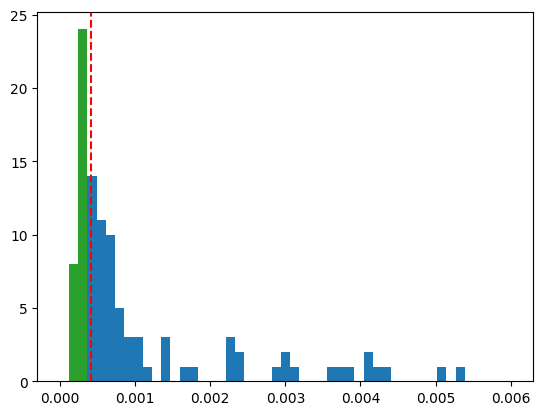

In [9]:
bins = np.linspace(0, 6e-3, 50)
plt.hist(df[df["prediction"] == 0]["loss"], bins, color="tab:green")
plt.hist(df[df["prediction"] == 1]["loss"], bins, color="tab:blue")
plt.axvline(x=decision_boundary, color="r", linestyle="--")

In [10]:
accuracy = sum(df["label"] == df["prediction"]) / len(df)
accuracy

0.8181818181818182

In [11]:
df.sort_values(by="loss", ascending=False).head(10)

,loss,label,prediction
57,0.005270,1,1
48,0.005032,1,1
108,0.004320,1,1
56,0.004219,1,1
107,0.004100,1,1
93,0.004068,1,1
101,0.003869,1,1
98,0.003746,1,1
100,0.003641,1,1
52,0.003116,1,1
